## House Prices: Advanced Regression Techniques

The dataset that we shall be using for the finl project is 'House Prices: Advanced Regression Techniques', obtained from Kaggle's current list of open competitions (https://www.kaggle.com/c/house-prices-advanced-regression-techniques). The goal is develop a regression model that accurately predicts the sale price of 1,459 houses using a subset of available features.  The following workbook document's our team's process in full - from exploratory data analysis, to model selection and evaluation.


In [1]:
# General libraries 
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Preprocessing and stats libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from scipy import stats

# SK-learn libraries for regression
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import AdaBoostClassifier 

# Other SK-learn libraries for learning
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

# SK-learn libraries for evaluation
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Pending tasks

# Boxplots of categorical variables
# Neighborhood and YearBuilt plot
# Scale all numerical values - LoabelEncoding vs. OneHot?
# Convert certain numical values to categorical, e.g. YearBuilt

### EDA

In [4]:
# Read in the housing train data
train = pd.read_csv('../Data/train.csv', index_col=0)

# Read in the test data
test = pd.read_csv('../Data/test.csv', index_col=0)

train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
# Shape of train data
print('Train data')
print('Rows:', len(train.index))
print('Cols:', len(train.columns), '\n')

# Shape of dev data
#print('Dev data')
#print('Rows:', len(dev.index))
#print('Cols:', len(dev.columns), '\n')  

# Shape of test data
print('Test data')
print('Rows:', len(test.index))
print('Cols:', len(test.columns)) 

Train data
Rows: 1460
Cols: 80 

Test data
Rows: 1459
Cols: 79


In [6]:
# Qualitative variables
qualitative = [var for var in train.columns if np.dtype(train[var]) == 'object']

# Quantitative variables
quantitative = [var for var in train.columns if np.dtype(train[var]) != 'object']

print('Qualitative variables:', len(qualitative))
print('Quantitative variables:', len(quantitative))
print(qualitative)

Qualitative variables: 43
Quantitative variables: 37
['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


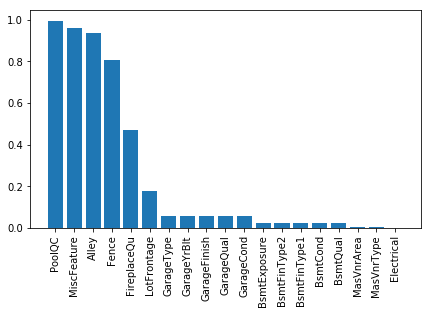

In [7]:
# Calculate missing value counts
missing = train.isnull().sum()
missing = pd.DataFrame(missing[missing > 0])

# Rename and sort counts
missing.columns = ['count']
missing.sort_values(by='count', ascending = False, inplace = True)

# Percentage missing
missing['percent_missing'] = missing['count'] / len(train.index)

# Plot missing counts
fig, ax = plt.subplots(figsize = (7,4))
plt.bar(missing.index, missing['percent_missing'])

# Rotate x labels
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

**Correlated variables:** The correlation plot shows there are a number of variables that are highly correlated, e.g. Overall Quality and Sale Price.  The extent to which the different variables are correlated will need to be taken into consideration when selecting the appropriate regression model.  For instance, we'll want to avoid high degree of multicollinearity in order to minimize the bias with our model.

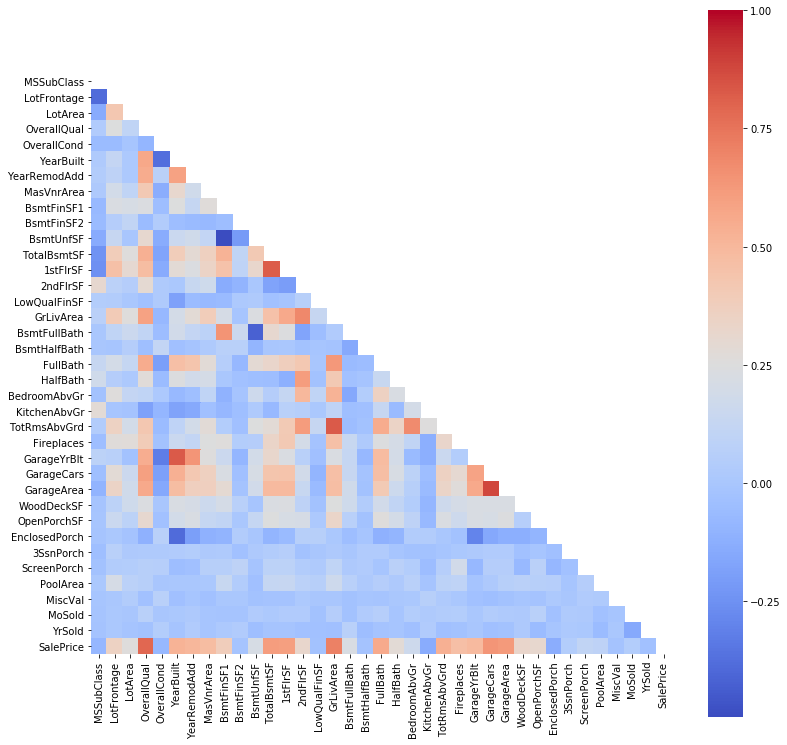

In [8]:
# Create correlation matrix
corr = train.corr()

# Define figure size
plt.rcParams['figure.figsize'] = (13, 13)

# Mask upper triangle
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Plot heapmat
sns.heatmap(corr, mask=mask, square=True, cmap='coolwarm')

In [9]:
# SalePrice correlations
saleprice_corr = pd.DataFrame(corr.loc[['SalePrice'], :].unstack())

# Reformat df and sort
saleprice_corr.rename(columns= {0: 'SalePrice'}, inplace = True)
saleprice_corr.reset_index(level=1, drop=True, inplace=True)
saleprice_corr.sort_values(by='SalePrice', ascending = False, inplace = True)

# Top 15 variables most strongly correlated with SalePrice
saleprice_top_15 = saleprice_corr.iloc[1:16, :]
saleprice_top_15

,SalePrice
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897
YearRemodAdd,0.507101


In [10]:
print('Correlation between GarageArea and GarageCars: {:.3f}'. format(corr.loc['GarageCars']['GarageArea']))

Correlation between GarageArea and GarageCars: 0.882


**Variables strongly correlated with sale price:** The 15 variables displayed above are those most strongly correlated with SalePrice, our dependent variable.  It's worth noting that some of thse variables are highly correlated with one another (e.g. GarageCars/GarageArea, GrLivArea/1stFlrSF) and so such pairings should be avoided when specifying the linear regression model so as not to confound results.

### The Dependent Variable - Sale Price

In [11]:
# Min and max sales price
print('Descriptive stats for sale price:')
round(train.SalePrice.describe(),2)

Descriptive stats for sale price:


count      1460.0
mean     180921.2
std       79442.5
min       34900.0
25%      129975.0
50%      163000.0
75%      214000.0
max      755000.0
Name: SalePrice, dtype: float64

Text(0,0.5,'Number of homes')

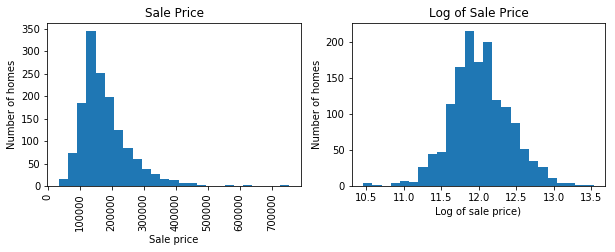

In [12]:
# Plot dependent variable
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,3))

# Histogram of sale price
ax1.hist(train.SalePrice, bins=25)

ax1.set_title('Sale Price')
ax1.set_xlabel('Sale price')
ax1.set_ylabel('Number of homes')

# Rotate x labels
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)
    
# Histogram of log(sale price) 
ax2.hist(np.log(train.SalePrice), bins=25)

ax2.set_title('Log of Sale Price')
ax2.set_xlabel('Log of sale price)')
ax2.set_ylabel('Number of homes')


### Combine Datasets and Replace NaNs

In [13]:
# Retain SalePrice but drop from train data
y_train = train['SalePrice']
train.drop('SalePrice', axis=1, inplace=True)

# Create full data
full_data = pd.concat((train, test)).reset_index(drop=True)
print('Full data:', full_data.shape)

Full data: (2919, 79)


In [14]:
# Quantitative variables where NaNs can be filled
# with more suitable value.

neighborhood_lot_mean = full_data.groupby('Neighborhood')['LotFrontage'].mean()
full_data['LotFrontage'] = neighborhood_lot_mean.transform(lambda x: x.fillna(x.mean))

In [15]:
# Replace all missing values: qualitative
# filled with none, quantitative with zero.

for col in missing.index:
    if col in qualitative:
        full_data[col] = full_data[col].fillna('None')
    elif col in quantitative:
        full_data[col] = full_data[col].fillna(0)


### Label Encoding

In [16]:
# Copy full data for modifications
full_modified = full_data

# Label encode all qualitative variables
for col in qualitative:
    label_encoder = LabelEncoder()
    label_encoder.fit(list(full_modified[col].values)) 
    full_modified[col] = label_encoder.transform(list(full_modified[col].values))

full_modified.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,3,0.0,8450,1,1,3,3,0,4,...,0,0,3,4,1,0,2,2008,8,4
1,20,3,0.0,9600,1,1,3,3,0,2,...,0,0,3,4,1,0,5,2007,8,4
2,60,3,0.0,11250,1,1,0,3,0,4,...,0,0,3,4,1,0,9,2008,8,4
3,70,3,0.0,9550,1,1,0,3,0,0,...,0,0,3,4,1,0,2,2006,8,0
4,60,3,0.0,14260,1,1,0,3,0,2,...,0,0,3,4,1,0,12,2008,8,4


### Segment data for model training

In [17]:
# Cut point for train/test post feature engineering
cut = train.shape[0]

# Recreate train and test sets
train = full_modified[:cut]
train.loc[:, 'SalePrice'] = list(y_train)
test_data = full_modified[cut:]

# Random splits for train and dev sets
train_set = train.sample(frac=0.8, random_state=0)
dev_set = train.drop(train_set.index)

print('train:', train_set.shape)
print('dev:', dev_set.shape)

train: (1168, 80)
dev: (292, 80)


In [18]:
# Select specified features for each dataset
train_data, train_labels = train_set.loc[:, train_set.columns != 'SalePrice'], train_set.loc[:, ['SalePrice']]
dev_data, dev_labels = dev_set.loc[:, dev_set.columns != 'SalePrice'], dev_set.loc[:, ['SalePrice']]
test_data = test

In [19]:
# Check that dataset has been constrained to specified features
print('train:', train_data.shape)
print('dev:', dev_data.shape)
print('test:', test_data.shape)

train: (1168, 79)
dev: (292, 79)
test: (1459, 79)


### Basic Linear Model

Linear regression
Accuracy: 0.8801


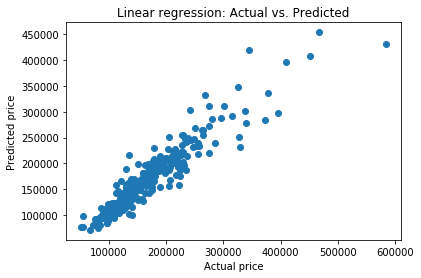

In [20]:
# Log of sales price
train_labels_log = np.log(train_labels)
dev_labels_log = np.log(dev_labels)

# Fit the linear regression model
lr = LinearRegression()
lr.fit(train_data, train_labels_log)
predict_dev_log = lr.predict(dev_data)
predict_dev_value = np.exp(predict_dev_log)

# Plot predicted vs. actual values
fig, ax = plt.subplots(figsize = (6,4))

#plt.scatter(dev_labels_log, predict_dev_log)
plt.scatter(dev_labels, predict_dev_value)

ax.set_title('Linear regression: Actual vs. Predicted')
ax.set_xlabel('Actual price')
ax.set_ylabel('Predicted price')

# R^2 of model
print('Linear regression')
print('Accuracy: {:.4f}'.format(lr.score(dev_data, dev_labels_log)))

In [21]:
# Use root mean square error to evaluate model accuracy.